In [12]:
!pip install torch torchvision matplotlib numpy pillow tensorflow scipy opencv-python

  Using cached opencv_python-4.11.0.86-cp37-abi3-macosx_13_0_arm64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-macosx_13_0_arm64.whl (37.3 MB)


In [13]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch
import torchvision

# Import TensorFlow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2



In [14]:
train_path = 'data/train'
test_path = 'data/test'
val_path = 'data/val'

#understand the data distribution
# Each path has 2 directories: NORMAL and PNEUMONIA
train_normal_path = os.path.join(train_path, 'NORMAL')
train_pneumonia_path = os.path.join(train_path, 'PNEUMONIA')
test_normal_path = os.path.join(test_path, 'NORMAL')
test_pneumonia_path = os.path.join(test_path, 'PNEUMONIA')
val_normal_path = os.path.join(val_path, 'NORMAL')
val_pneumonia_path = os.path.join(val_path, 'PNEUMONIA')

# Count images in each category
train_normal_count = len(os.listdir(train_normal_path))
train_pneumonia_count = len(os.listdir(train_pneumonia_path))
test_normal_count = len(os.listdir(test_normal_path))
test_pneumonia_count = len(os.listdir(test_pneumonia_path))
val_normal_count = len(os.listdir(val_normal_path))
val_pneumonia_count = len(os.listdir(val_pneumonia_path))

# Count pneumonia by type (virus or bacteria)
train_pneumonia_files = os.listdir(train_pneumonia_path)
train_virus_count = sum(1 for f in train_pneumonia_files if 'virus' in f.lower())
train_bacteria_count = sum(1 for f in train_pneumonia_files if 'bacteria' in f.lower())

test_pneumonia_files = os.listdir(test_pneumonia_path)
test_virus_count = sum(1 for f in test_pneumonia_files if 'virus' in f.lower())
test_bacteria_count = sum(1 for f in test_pneumonia_files if 'bacteria' in f.lower())

val_pneumonia_files = os.listdir(val_pneumonia_path)
val_virus_count = sum(1 for f in val_pneumonia_files if 'virus' in f.lower())
val_bacteria_count = sum(1 for f in val_pneumonia_files if 'bacteria' in f.lower())

# Print label distribution
print(f"Training set   - NORMAL: {train_normal_count}, PNEUMONIA: {train_pneumonia_count} (Virus: {train_virus_count}, Bacteria: {train_bacteria_count})")
print(f"Testing set    - NORMAL: {test_normal_count}, PNEUMONIA: {test_pneumonia_count} (Virus: {test_virus_count}, Bacteria: {test_bacteria_count})")
print(f"Validation set - NORMAL: {val_normal_count}, PNEUMONIA: {val_pneumonia_count} (Virus: {val_virus_count}, Bacteria: {val_bacteria_count})")


Training set   - NORMAL: 1341, PNEUMONIA: 3875 (Virus: 1345, Bacteria: 2530)
Testing set    - NORMAL: 234, PNEUMONIA: 390 (Virus: 148, Bacteria: 242)
Validation set - NORMAL: 8, PNEUMONIA: 8 (Virus: 0, Bacteria: 8)


## Preprocessing


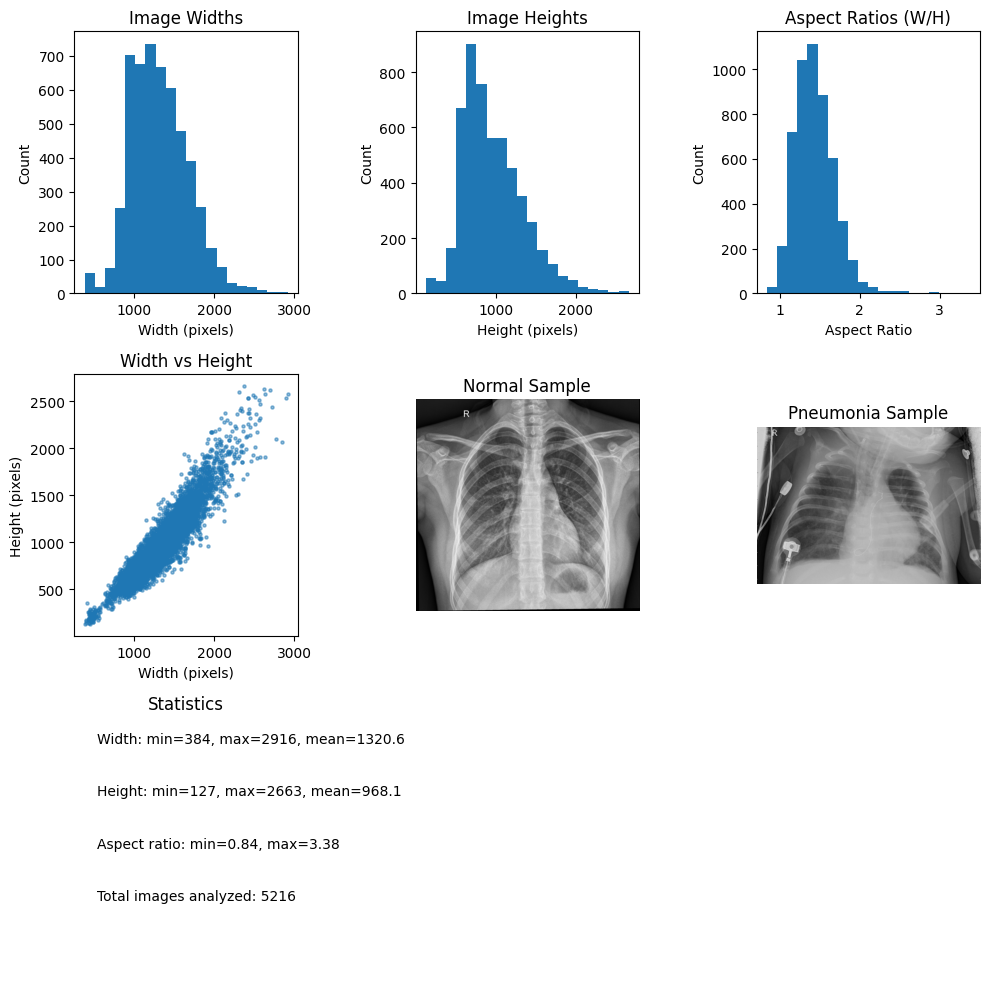

Image size analysis complete.
Average dimensions: 1320.6 x 968.1 pixels
Dimension range: Width 384-2916, Height 127-2663
Average aspect ratio: 1.440


In [ ]:
# Analyze image size and proportion distribution
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Function to analyze images in a directory
def analyze_images(directory):
    sizes = []
    aspect_ratios = []
    
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            for img_file in os.listdir(category_path):
                img_path = os.path.join(category_path, img_file)
                try:
                    img = cv2.imread(img_path)
                    if img is not None:
                        height, width = img.shape[:2]
                        sizes.append((width, height))
                        aspect_ratios.append(width / height)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
    
    return sizes, aspect_ratios

# Analyze images in training set
train_sizes, train_aspect_ratios = analyze_images(train_path)

# Create histograms and visualizations
plt.figure(figsize=(10, 10))

# Plot image widths
plt.subplot(3, 3, 1)
plt.hist([w for w, h in train_sizes], bins=20)
plt.title('Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Count')

# Plot image heights
plt.subplot(3, 3, 2)
plt.hist([h for w, h in train_sizes], bins=20)
plt.title('Image Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Count')

# Plot aspect ratios
plt.subplot(3, 3, 3)
plt.hist(train_aspect_ratios, bins=20)
plt.title('Aspect Ratios (W/H)')
plt.xlabel('Aspect Ratio')
plt.ylabel('Count')

# Scatter plot of width vs height
plt.subplot(3, 3, 4)
plt.scatter([w for w, h in train_sizes], [h for w, h in train_sizes], alpha=0.5, s=5)
plt.title('Width vs Height')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')

# Plot some sample images
plt.subplot(3, 3, 5)
normal_sample = os.path.join(train_normal_path, os.listdir(train_normal_path)[0])
img = cv2.imread(normal_sample)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('Normal Sample')
plt.axis('off')

plt.subplot(3, 3, 6)
pneumonia_sample = os.path.join(train_pneumonia_path, os.listdir(train_pneumonia_path)[0])
img = cv2.imread(pneumonia_sample)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('Pneumonia Sample')
plt.axis('off')

# Calculate and print statistics
widths = [w for w, h in train_sizes]
heights = [h for w, h in train_sizes]

plt.subplot(3, 3, 7)
plt.text(0.1, 0.9, f"Width: min={min(widths)}, max={max(widths)}, mean={np.mean(widths):.1f}", fontsize=10)
plt.text(0.1, 0.7, f"Height: min={min(heights)}, max={max(heights)}, mean={np.mean(heights):.1f}", fontsize=10)
plt.text(0.1, 0.5, f"Aspect ratio: min={min(train_aspect_ratios):.2f}, max={max(train_aspect_ratios):.2f}", fontsize=10)
plt.text(0.1, 0.3, f"Total images analyzed: {len(train_sizes)}", fontsize=10)
plt.axis('off')
plt.title('Statistics')

plt.tight_layout()
plt.show()

print("Image size analysis complete.")
print(f"Average dimensions: {np.mean(widths):.1f} x {np.mean(heights):.1f} pixels")
print(f"Dimension range: Width {min(widths)}-{max(widths)}, Height {min(heights)}-{max(heights)}")
print(f"Average aspect ratio: {np.mean(train_aspect_ratios):.3f}")


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


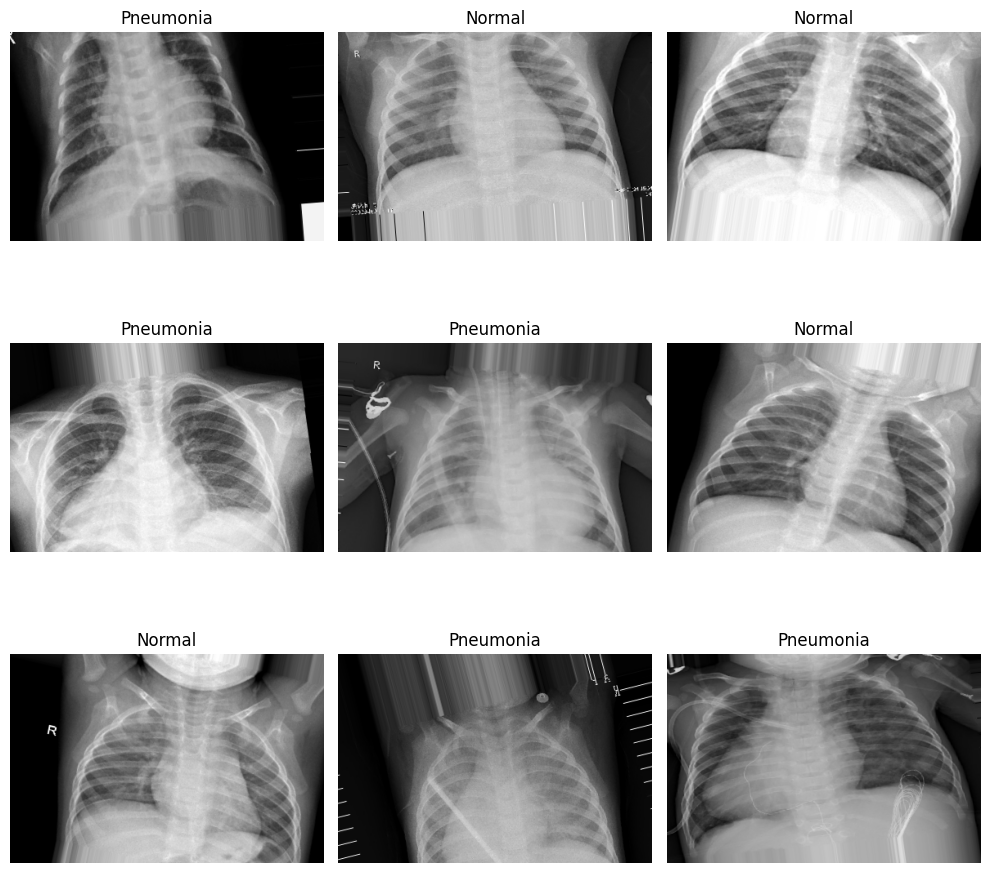

Training data shape: (32, 256, 384, 3)
Min pixel value: 0.0, Max pixel value: 1.0
Using scaled dimensions: 384x256 (original avg: 1320.6x968.1)
Aspect ratio: 1.500 (original avg: 1.440)


In [16]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt
import numpy as np

# Define image dimensions based on the analysis
# Using dimensions closer to the average while maintaining a reasonable size for the model
IMG_HEIGHT = 256  # Scaled down from average of 968.1
IMG_WIDTH = 384   # Scaled down from average of 1320.6, maintaining aspect ratio ~1.44
BATCH_SIZE = 32

# Create ImageDataGenerator for data augmentation and preprocessing
# For training data, we'll apply some augmentation to help with generalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,  # X-rays can be flipped horizontally without changing diagnosis
    fill_mode='nearest'
)

# For validation and test data, we only rescale
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess the training data
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

# Load and preprocess the validation data
validation_generator = val_test_datagen.flow_from_directory(
    val_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Load and preprocess the test data
test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Display some sample images from the training set
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for i in range(min(9, len(image_batch))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i])
        plt.title('Normal' if label_batch[i] == 0 else 'Pneumonia')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Get a batch of training images
image_batch, label_batch = next(iter(train_generator))
show_batch(image_batch, label_batch)

print(f"Training data shape: {image_batch.shape}")
print(f"Min pixel value: {image_batch.min()}, Max pixel value: {image_batch.max()}")
print(f"Using scaled dimensions: {IMG_WIDTH}x{IMG_HEIGHT} (original avg: 1320.6x968.1)")
print(f"Aspect ratio: {IMG_WIDTH/IMG_HEIGHT:.3f} (original avg: 1.440)")
